**Pool Performance and TVL Evaluation**

This script will be used to explore pool performance and TVL.

In the script, we will:

1. Create a scatter plot to show the relationship between pool TVL and 7-day return
2. Add a column for the percentile rank of the pool 7-day return
3. Explore what are the best performing pools and projects
4. Create a table that has provides a league standing of pools with pool name, pool id, chain, protocol, tvl, 7 day change in TVL, APY, 7 day, 30 day apy,  7day mean apy divided by 7 day std dev, 7 day apy percentile, 30 day apy percentile, tvl percentile, 7 day apy percentile
5. Create a function that plots a line graph of the 7 day APY for a pool over time based on a list of pool ids
6. add a new column to the table called 'SD_Score' which is the product of '7 day APY percentile' and 'tvl percentile' multiplied by 100
7. create another column called 'SD_Score_std' which is the standard deviation of the SD_Score over the last 7 days




In [11]:
# Import libraries and dependencies
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from PIL import Image
from io import BytesIO
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
from datetime import timedelta

data = pd.read_csv(r'/Users/karolk/Python_Work/Data_Sets/Global_Data/DeFi_Global_DB.csv', index_col=0)
pd.set_option("display.max.columns", None)
pd.set_option("display.precision", 4)
pd.options.display.float_format = '{:,.2f}'.format

display(data.head())


,chain,project,symbol,tvlUsd,apy,pool,stablecoin,ilRisk,exposure,outlier,apyMean30d,date,time added,new_upload,possible_error
id,,,,,,,,,,,,,,,
2505286,Ethereum,uniswap-v2,BLOCK-WETH,"216,991.00",0.00,ffff4226-4328-404f-be4c-428d01a06ccd,False,yes,multi,False,0.00,2023-12-03,2023-12-03 07:01:18,False,False
2492795,Ethereum,uniswap-v2,BLOCK-WETH,"204,392.00",0.00,ffff4226-4328-404f-be4c-428d01a06ccd,False,yes,multi,False,0.00,2023-12-02,2023-12-02 07:01:20,False,False
2480300,Ethereum,uniswap-v2,BLOCK-WETH,"194,546.00",0.00,ffff4226-4328-404f-be4c-428d01a06ccd,False,yes,multi,False,0.00,2023-12-01,2023-12-01 07:01:34,False,False
2467503,Ethereum,uniswap-v2,BLOCK-WETH,"206,344.00",0.00,ffff4226-4328-404f-be4c-428d01a06ccd,False,yes,multi,False,0.00,2023-11-30,2023-11-30 07:09:43,False,False
2454924,Ethereum,uniswap-v2,BLOCK-WETH,"209,586.00",0.00,ffff4226-4328-404f-be4c-428d01a06ccd,False,yes,multi,False,0.00,2023-11-29,2023-11-29 07:08:22,False,False


In [12]:
#set date and time added as datetime objects
data['date'] = pd.to_datetime(data['date'])
data['time added'] = pd.to_datetime(data['time added'])

#drop all pools that have a TVL of 0 or a APY of 0
data = data[(data['tvlUsd'] > 0) & (data['apy'] > 0)]

#select only stablecoin pools
data = data[data['stablecoin'] == True]

#sort the data table by pool and by date
data = data.sort_values(['pool', 'date'], ascending=[True, True]).reset_index(drop=True)

#create a new column which would the average APY over the last 7 days using the 'apy' column
data['apyMean7d'] = data.groupby('pool')['apy'].transform(lambda x: x.rolling(7, 1).mean())

#create a new column for the standard deviation of the APY over the last 7 days
data['apyStd7d'] = data.groupby('pool')['apy'].transform(lambda x: x.rolling(7, 1).std())

#create a column which has the percentile for TVL for the TVL at each date
data['tvlPercentile'] = data.groupby('date')['tvlUsd'].rank(pct=True)

#create a column which has the percentile for 7 day APY and 30 day APY
data['apy7DPercentile'] = data.groupby('date')['apyMean7d'].rank(pct=True)
data['apy30DPercentile'] = data.groupby('date')['apyMean30d'].rank(pct=True)

#create a new column in 'data' to categorize the pools by their 7 day and 30 day APY using the following groupings 0-5%, 5-10%, 10-15%, 15-20%, 20-25%, 25%+
data['apy7DGroup'] = pd.cut(data['apyMean7d'], bins=[0, 5, 10, 15, 20, 25, 100], labels=['0-5%', '5-10%', '10-15%', '15-20%', '20-25%', '25%+'])
data['apy30DGroup'] = pd.cut(data['apyMean30d'], bins=[0, 5, 10, 15, 20, 25, 100], labels=['0-5%', '5-10%', '10-15%', '15-20%', '20-25%', '25%+'])

#creating 2 new columns which is the average APY for 7 days divided by the standard deviation of the APY for 7 days
data['apy7DStdRatio'] = data['apyMean7d'] / data['apyStd7d']

#adding a column to categorize the pools by their percentile rank of TVL, 7day and 30 day rank using 10 bins
data['tvlPercGroup'] = pd.cut(data['tvlPercentile'], bins=10, labels=['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%'])
data['apy7DPercGroup'] = pd.cut(data['apy7DPercentile'], bins=10, labels=['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%'])
data['apy30DPercGroup'] = pd.cut(data['apy30DPercentile'], bins=10, labels=['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%'])

#calculate a new column for the change in TVL over the last 7 days
data['tvlChange7d'] = data.groupby(['pool'])['tvlUsd'].pct_change(periods=7) * 100

data['tvlChange1d'] = data.groupby(['pool'])['tvlUsd'].pct_change(periods=1) * 100

#creating column with 'SD_Score' which is the product of '7 day APY percentile' and 'tvl percentile' multiplied by 100
data['SD_Score'] = data['apy7DPercentile'] * data['tvlPercentile'] * 100

#creating a column 'SD_Score_7D' which is the rolling mean of the past 7 days SD score
data['SD_Score_7D_avg'] = data.groupby('pool')['SD_Score'].transform(lambda x: x.rolling(7, 1).mean())

#create a column 'SD_Score_7D_std' which is the standard deviation of the SD_Score_7D over the last 7 days
data['SD_Score_7D_std'] = data.groupby('pool')['SD_Score'].transform(lambda x: x.rolling(7, 1).std())

In [13]:
#checking summary statistics of SD Score
display(data['SD_Score'].describe())



count   340,934.00
mean         25.16
std          20.80
min           0.00
25%           6.85
50%          20.99
75%          39.17
max          97.27
Name: SD_Score, dtype: float64

In [14]:
#display(data.head())

#display data for 1 pool
check = (data[data['pool'] == '728b0a54-57bd-40b7-beff-967ac78f4fbc'])

#slect only the data for 'pool', 'date', 'tvl', 'apy' , 'apyMean7d', 'apyStd7d','tvlChange7d', 'tvlChange1d'
check = check[['pool', 'date', 'tvlUsd', 'apy', 'apyMean7d', 'apyStd7d','tvlChange7d', 'tvlChange1d', 'SD_Score', 'SD_Score_7D_avg', 'SD_Score_7D_std']]

check


,pool,date,tvlUsd,apy,apyMean7d,apyStd7d,tvlChange7d,tvlChange1d,SD_Score,SD_Score_7D_avg,SD_Score_7D_std
153168,728b0a54-57bd-40b7-beff-967ac78f4fbc,2023-04-26,"80,692,189.00",2.14,2.14,NaN,NaN,NaN,26.30,26.30,NaN
153169,728b0a54-57bd-40b7-beff-967ac78f4fbc,2023-05-03,"114,654,907.00",2.34,2.24,0.14,NaN,42.09,28.13,27.22,1.29
153170,728b0a54-57bd-40b7-beff-967ac78f4fbc,2023-05-09,"114,676,812.00",2.05,2.17,0.15,NaN,0.02,26.62,27.02,0.98
153171,728b0a54-57bd-40b7-beff-967ac78f4fbc,2023-05-10,"114,773,579.00",2.00,2.13,0.15,NaN,0.08,26.51,26.89,0.84
153172,728b0a54-57bd-40b7-beff-967ac78f4fbc,2023-05-12,"114,648,223.00",1.95,2.09,0.15,NaN,-0.11,27.95,27.10,0.87
...,...,...,...,...,...,...,...,...,...,...,...
153378,728b0a54-57bd-40b7-beff-967ac78f4fbc,2023-12-13,"35,047,710.00",6.49,6.41,2.06,-45.27,0.07,45.39,41.50,3.04
153379,728b0a54-57bd-40b7-beff-967ac78f4fbc,2023-12-14,"35,130,536.00",6.52,6.67,1.92,-45.12,0.24,46.15,42.50,3.28
153380,728b0a54-57bd-40b7-beff-967ac78f4fbc,2023-12-15,"35,025,746.00",6.46,7.00,1.57,-45.36,-0.30,47.63,43.78,3.29
153381,728b0a54-57bd-40b7-beff-967ac78f4fbc,2023-12-16,"35,056,879.00",6.60,7.34,1.03,-45.26,0.09,49.09,45.34,2.72


In [15]:

#create all the needed tables for the scatter plot
latest_stables = data[data['date'] == data['date'].max()]
#select only stablecoin pools for the latest_stables dataframe
latest_stables = latest_stables[latest_stables['stablecoin'] == True]

#create tables to look at total locked in value by chain and protocol
TVL_chain = latest_stables.pivot_table(index='chain', values='tvlUsd', aggfunc='sum').sort_values('tvlUsd', ascending=False).head(10)
#TVL by protocol
TVL_protocol = latest_stables.pivot_table(index='project', values='tvlUsd', aggfunc='sum').sort_values('tvlUsd', ascending=False).head(30)

#create a new column to identify top 10 chains named 'top_10_chain'
latest_stables['top_10_chain'] = latest_stables['chain'].isin(TVL_chain.index)

#create a new column to identify top 30 protocols named 'top_30_project'
latest_stables['top_30_project'] = latest_stables['project'].isin(TVL_protocol.index)

#setting up a cut of data with only largest chains and largest protocols
APY_analysis = latest_stables[(latest_stables['top_10_chain']) & (latest_stables['top_30_project'])]

#creating 3 dataframe to sum the number of pools in each grouping for TVLPercGroup, 7 day APY and 30 day APY groupings

tvl_count = APY_analysis.groupby('tvlPercGroup').count()['pool']
apy7d_count = APY_analysis.groupby('apy7DPercGroup').count()['pool']
apy30d_count = APY_analysis.groupby('apy30DPercGroup').count()['pool']


In [16]:
# Setting the plotting theme
sns.set_theme(style="ticks", context='talk')

#importing image for watermark
img = Image.open(r'/Users/karolk/Python_Work/Data_Sets/logo.png')

#setting up font for chart
fontpath = '/System/Library/Fonts/Optima.ttc'
prop = font_manager.FontProperties(fname=fontpath)
plt.rcParams['font.family'] = prop.get_name()

#creating string that says "Data updated as of: mmm dd yyyy"
date = latest_stables['date'].max()
date = pd.to_datetime(date)
date = date.strftime('%b %d %Y')
date = 'Data updated as of: ' + date


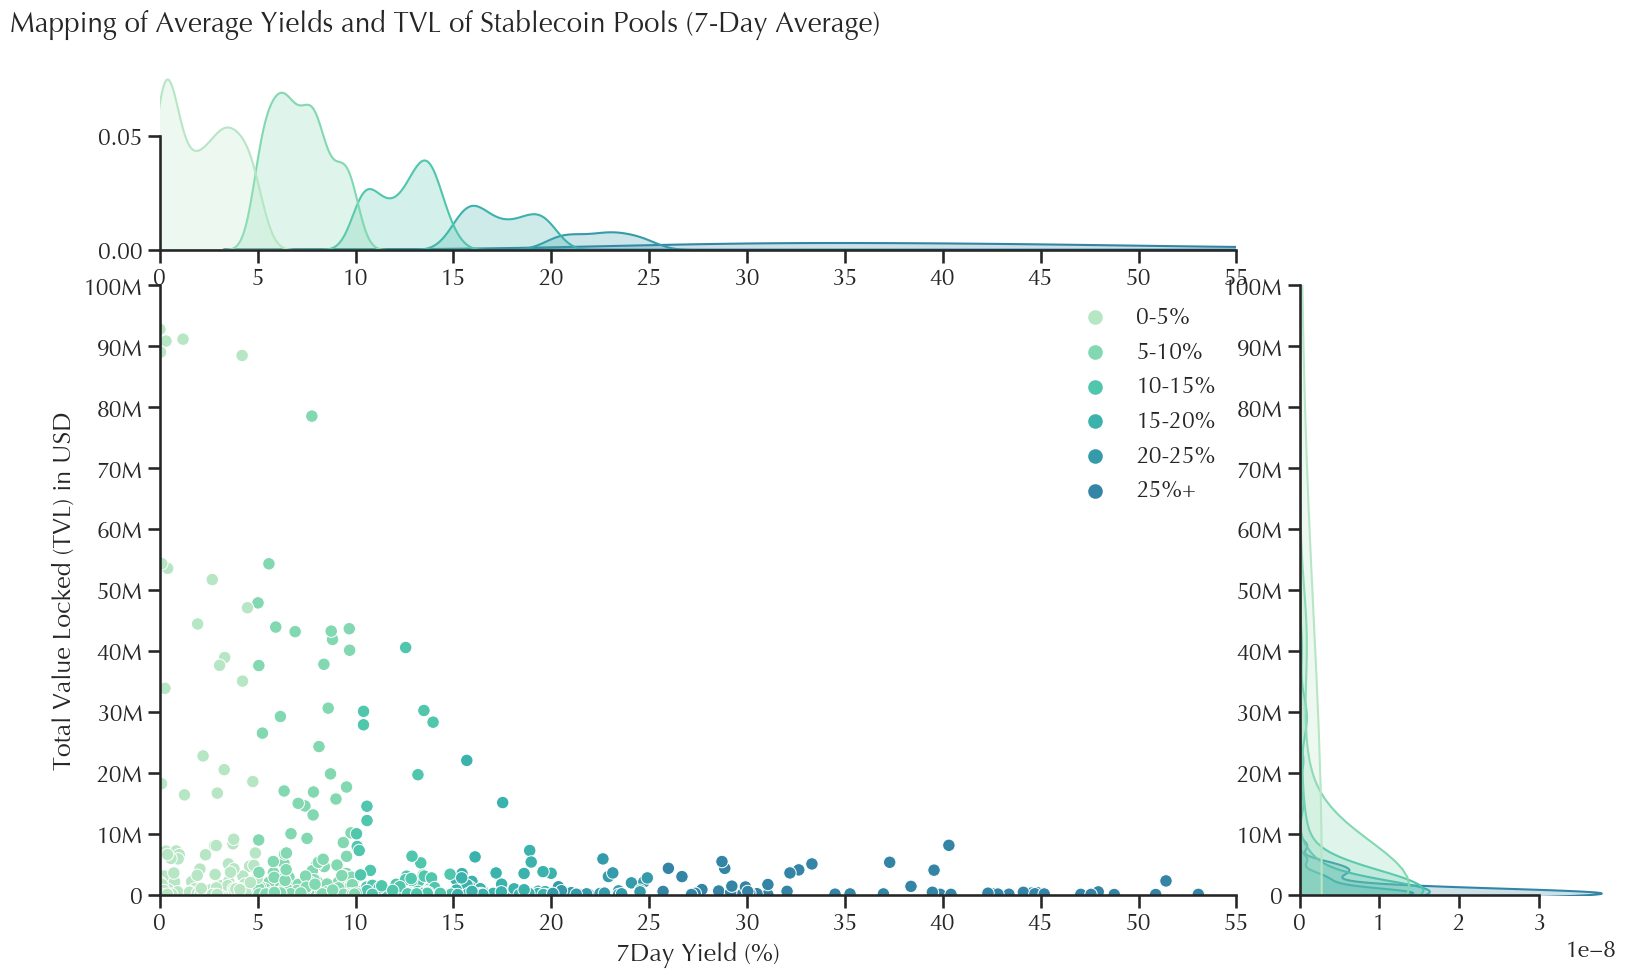

In [17]:
#Creating a joinplot to visualize a smaller universe of investable assets, select a subset of the data that shows 75% of the data excluding outliers

#setting color palatte for chart
sns.set_palette("mako_r",12)

#create chart
g = sns.jointplot(x='apyMean7d', y='tvlUsd', data=APY_analysis,
                  height=15, ratio=3, space=0.2, hue='apy7DGroup',
                  xlim=(0, 50), ylim=(2000000, 100000000), kind='scatter')


#setting the title and labels
g.fig.suptitle('Mapping of Average Yields and TVL of Stablecoin Pools (7-Day Average)',
               y=1.05, size=20, weight='bold', x=0.25)
plt.xlabel('7Day Yield (%)')
plt.ylabel('Total Value Locked (TVL) in USD')


#set the legend location
plt.legend(loc='best', frameon=False)

#set size of chart
g.fig.set_size_inches(16, 9)

#adjusting the tick marks
plt.yticks([0, 10000000, 20000000, 30000000, 40000000, 50000000, 60000000, 70000000, 80000000, 90000000, 100000000], ['0','10M', '20M', '30M', '40M', '50M', '60M', '70M', '80M', '90M', '100M'])
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55], ['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55'])

#despine the plot
sns.despine(trim=True, offset=0)

#save the figure
plt.show()
plt.cla()
plt.clf()
plt.close()

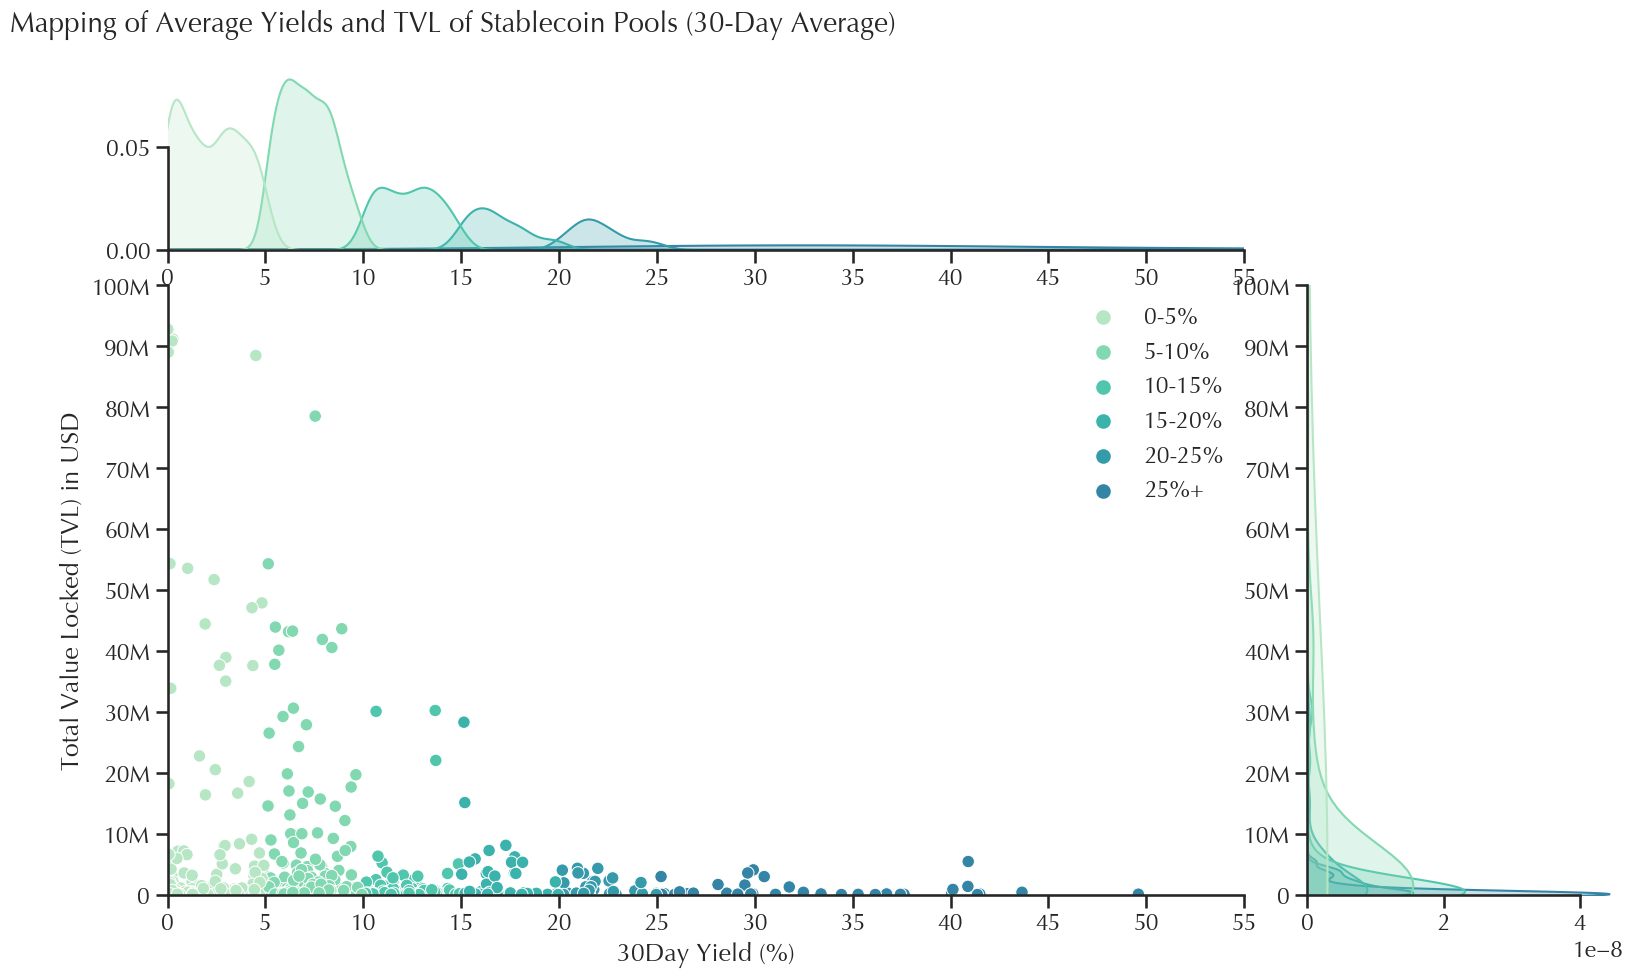

In [18]:
#Creating a joinplot to visualize a smaller universe of investable assets, select a subset of the data that shows 75% of the data excluding outliers

#setting color palatte for chart
sns.set_palette("mako_r",12)

#create chart
g = sns.jointplot(x='apyMean30d', y='tvlUsd', data=APY_analysis,
                  height=15, ratio=3, space=0.2, hue='apy30DGroup',
                  xlim=(0, 50), ylim=(2000000, 100000000), kind='scatter')


#setting the title and labels
g.fig.suptitle('Mapping of Average Yields and TVL of Stablecoin Pools (30-Day Average)',
               y=1.05, size=20, weight='bold', x=0.25)
plt.xlabel('30Day Yield (%)')
plt.ylabel('Total Value Locked (TVL) in USD')


#set the legend location
plt.legend(loc='best', frameon=False)

#set size of chart
g.fig.set_size_inches(16, 9)

#adjusting the tick marks
plt.yticks([0, 10000000, 20000000, 30000000, 40000000, 50000000, 60000000, 70000000, 80000000, 90000000, 100000000], ['0','10M', '20M', '30M', '40M', '50M', '60M', '70M', '80M', '90M', '100M'])
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55], ['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55'])

#despine the plot
sns.despine(trim=True, offset=0)

#showing the figure
plt.show()
plt.cla()
plt.clf()
plt.close()


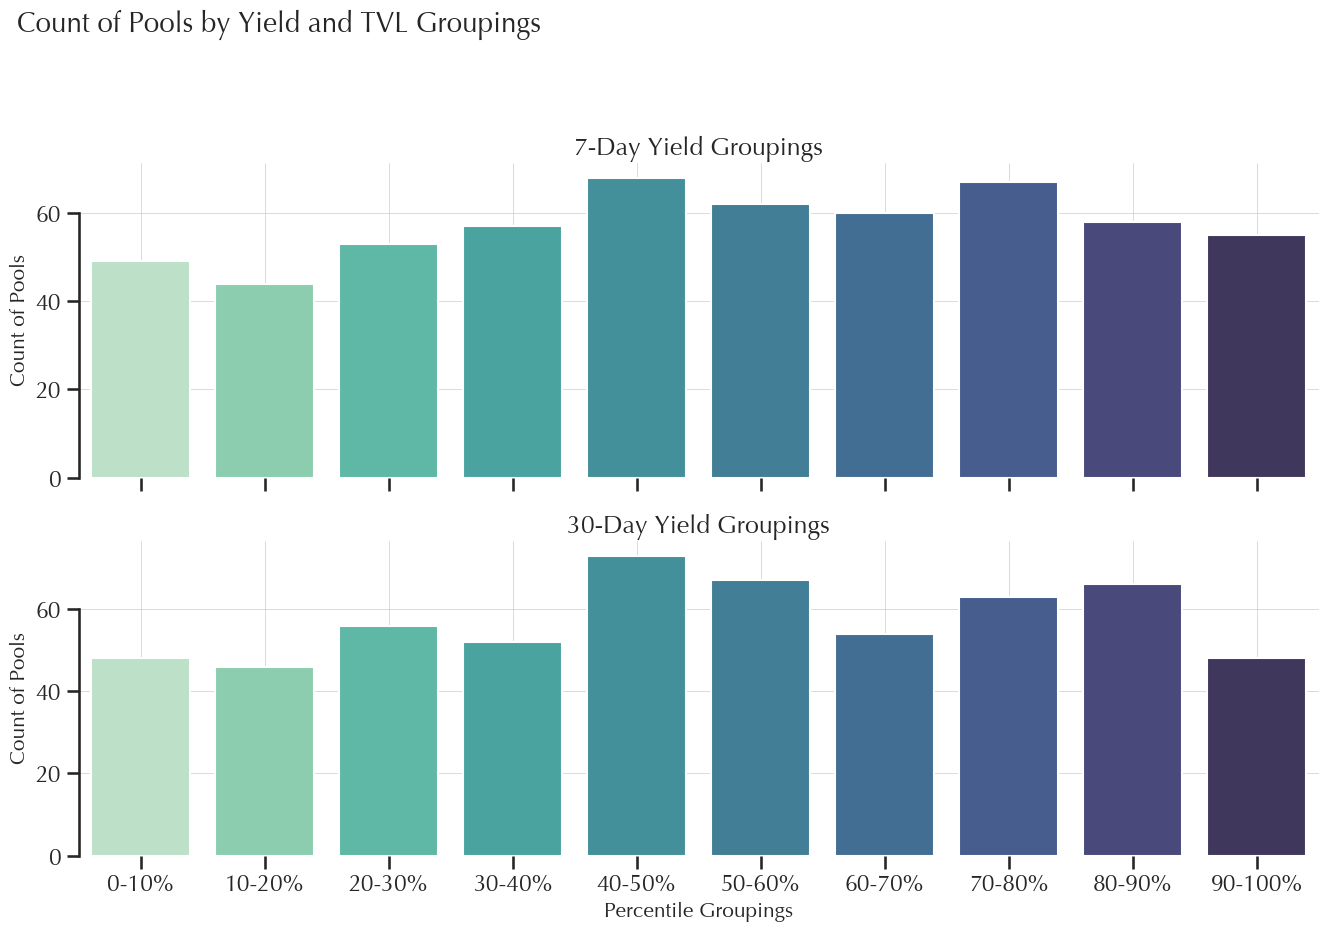

In [19]:
#create a bar graph with a shared x-axis for the count of pools in each grouping for TVL, 7 day APY and 30 day APY

#setting color palatte for chart
sns.set_palette("mako_r",12)

#create chart
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 9))

#plot the data
sns.barplot(x=apy7d_count.index, y=apy7d_count, ax=ax1)
sns.barplot(x=apy30d_count.index, y=apy30d_count, ax=ax2)

#set the title and labels
fig.suptitle('Count of Pools by Yield and TVL Groupings', y=1.05, size=20, weight='bold', x=0.25)
ax1.set_ylabel('Count of Pools', size=15)
ax2.set_ylabel('Count of Pools', size=15)
ax2.set_xlabel('Percentile Groupings', size=15)
ax1.set_xlabel(None)

#setting title for each subplot
ax1.set_title('7-Day Yield Groupings')
ax2.set_title('30-Day Yield Groupings')

#make grid lines thinner
ax1.grid(linewidth=0.5)
ax2.grid(linewidth=0.5)

#despine the plot
sns.despine(trim=True, bottom=True, offset=0)

#showing the figure
plt.show()
plt.cla()
plt.clf()
plt.close()



In [20]:
#create pool league standing dataframe which contains the following columns: 'pool name', 'pool id', 'chain', 'protocol', 'tvl', '7 day' 'change in TVL', 'APY', '7 day apy', '30 day apy',  '7day mean apy divided by 7 day std dev', '7 day apy percentile' '30 day apy percentile', 'tvl percentile', '7 day apy percentile'

#start with getting the list of all the columns in the data dataframe

columns_2_keep = [ 'date', 'chain', 'project', 'pool', 'symbol', 'tvlUsd',
                   'tvlChange1d', 'tvlChange7d' , 'apy', 'apyMean7d',
                   'apyStd7d', 'apyMean30d', 'apy7DStdRatio', 'SD_Score',
                   'SD_Score_7D_avg','stablecoin']

#creating a new dataframe with only the columns we want
pool_league_standings = data[columns_2_keep]

#creating a new dataframe with only rows where data is the latest date and 'stablecoin' is 'True'
pool_league_stable = pool_league_standings[(pool_league_standings['date'] == pool_league_standings['date'].max()) & (pool_league_standings['stablecoin'] == True)]

#sort the dataframe by SD_score and select the top 10 pools
top10_league_stable = pool_league_stable.sort_values(by='SD_Score_7D_avg', ascending=False).head(20)

#in the top10_league_stable dataframe, we will only keep the following columns: 'SD_Score_7D_avg', 'chain', 'project', 'symbol', 'tvlUsd', 'tvlChange7d' , 'apy', 'apyMean7d'
top10_league_stable = top10_league_stable[['SD_Score_7D_avg', 'chain', 'project', 'symbol', 'tvlUsd', 'tvlChange7d' , 'apy', 'apyMean7d']]

#making tvl in millions by dividing by 1 million
top10_league_stable['tvlUsd'] = top10_league_stable['tvlUsd'] / 1000000

#rounding the all numeric columns to 2 decimal places
top10_league_stable = top10_league_stable.round(2)

#renaming the columns
top10_league_stable = top10_league_stable.rename(columns={'SD_Score_7D_avg': 'SD Score', 'chain': 'Chain', 'project': 'Protocol', 'symbol': 'Symbol', 'tvlUsd': 'TVL (Millions)', 'tvlChange7d': 'TVL Change (7D)' , 'apy': 'APY (%)', 'apyMean7d': '7D APY (%)'})

#saving the dataframe to csv
top10_league_stable.to_csv('/Users/karolk/Python_Work/Pool_Analysis/League_Standings/top10_league_stable.csv')



#sort the data frame by TVL and select the top 10 pools
top10TVL_league_stable = pool_league_stable.sort_values(by='tvlUsd', ascending=False).head(20)

#sort the data frame by TVL and select the top 10 pools
top10APY_league_stable = pool_league_stable.sort_values(by='apyMean7d', ascending=False).head(20)

#save the top10TVL and top10APY dataframes to csv
top10TVL_league_stable.to_csv('/Users/karolk/Python_Work/Pool_Analysis/League_Standings/top10TVL_league_stable.csv')
top10APY_league_stable.to_csv('/Users/karolk/Python_Work/Pool_Analysis/League_Standings/top10APY_league_stable.csv')

#display the dataframe
top10_league_stable



,SD Score,Chain,Protocol,Symbol,TVL (Millions),TVL Change (7D),APY (%),7D APY (%)
62458,90.32,Arbitrum,abracadabra,MIM-USDC-USDT,17.20,7.04,36.62,37.31
20579,85.32,Sui,navi-protocol,USDC,15.00,NaN,26.11,26.55
215025,83.31,BSC,pancakeswap-amm-v3,USDT-BUSD,8.09,2.14,11.19,40.31
142606,83.27,Solana,orca,USDC-USDT,4.41,65.04,23.93,31.20
327844,83.00,Arbitrum,beefy,MIM-ARBUSDCE-USDT,4.02,30.57,38.21,39.55
99257,83.00,Arbitrum,merkl,STEUR-USDC,4.06,18.09,30.22,32.64
185250,82.70,Ethereum,pancakeswap-amm-v3,USDC-USDT,5.31,-12.24,34.53,37.29
45877,82.44,Arbitrum,solv-funds,USDT,2.17,NaN,72.79,80.07
295150,82.01,Arbitrum,vela-exchange,USDC,6.11,-4.38,23.43,22.90
168762,81.33,Ethereum,curve-dex,IDAI-IUSDC-IUSDT,5.04,0.30,40.27,33.31


In [21]:
#creating a function that will plot a line graph of the 7 day apy over time for a given list of pools

def plot_apy_over_time(pool_list, period, title, save_path):

    #creating a new dataframe with only the rows that contain the pools in the pool_list
    pool_list_df = data[data['pool'].isin(pool_list)]

    #selecting on the rows after the start date
    start_date = data['date'].max() - timedelta(days=period)
    pool_list_df = pool_list_df[pool_list_df['date'] >= start_date]

    #create a new column which is called 'pool name' which is the combination of 'project', ' ' and 'symbol'
    pool_list_df['pool name'] = pool_list_df['project'] + ' ' + pool_list_df['symbol']

    #creating a new dataframe with only the columns we want
    pool_list_df = pool_list_df[['date', 'pool name', 'apyMean7d']]

    #sort the dataframe by date in ascending order
    pool_list_df = pool_list_df.sort_values(by=['pool name', 'date'], ascending=True)

    #setting 'date' as the index column
    pool_list_df = pool_list_df.set_index('date')

    #divide the 'apyMean7d' by 100 to get the percentage
    pool_list_df['apyMean7d'] = pool_list_df['apyMean7d'] / 100

    #setting up font for chart
    fontpath = '/System/Library/Fonts/Optima.ttc'
    prop = font_manager.FontProperties(fname=fontpath)
    plt.rcParams['font.family'] = prop.get_name()

    #set theme to whitegrid for sns lineplot
    sns.set_theme(style='ticks', context='talk')

    #create figure and axis
    fig, ax = plt.subplots(figsize=(16, 9))

    #change legend to smaller font
    plt.rcParams['legend.fontsize'] = 10

    #change legend to display the pool name of the pool
    ax.legend(labels='pool name', loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

    #display the x tick date as a date in the format of %m-%d-%Y
    pool_list_df.index = pool_list_df.index.strftime('%Y-%m-%d')
    
    #creating a line plot of the data
    sns.lineplot(data=pool_list_df, x='date', y='apyMean7d', hue='pool name',
                 dashes=False, palette='mako', linewidth=2.5, ax=ax, errorbar=None)

    #despine the plot to keep only y and x axis
    sns.despine(offset=0, bottom=False, left=False)

    #edit x labels to be more readable
    ax.set_xticklabels(pool_list_df.index, rotation=45, ha='right')

    #set y label values to be percentages
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])

    #importing image for watermark
    img = Image.open(r'/Users/karolk/Python_Work/Data_Sets/logo.png')

    #adding watermark
    imagebox = OffsetImage(img, zoom=0.8, alpha=0.2)
    imagebox.image.axes = ax
    ao = AnnotationBbox(imagebox, (0.5, 0.5), xycoords='axes fraction', bboxprops={'lw':0})
    ao.patch.set_alpha(0)
    ax.add_artist(ao)

    #update font for plot to the font we set up
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontproperties(prop)

    #set the location of the legend to the best location
    ax.legend(loc='best', ncol=1, frameon=False)

    #setting the title and labels
    ax.set_title(title,
                 y=1.05, size=25, weight='bold', x=0.2)

    #setting the x and y labels
    ax.set_xlabel('Date', size=15, weight='bold')
    ax.set_ylabel('7 Day APY', size=15, weight='bold')

    #set the font size of x and y ticks
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

    #add a very fine grid to the plot
    ax.grid(visible=True, which='major', linestyle='-', alpha=0.2)

    #change the title of legend to 'Project & Pool Name'
    ax.legend(title='Project & Pool Name', loc='best', ncol=1, frameon=False)

    #save the figure
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')

    #showing the figure
    plt.show()
    plt.cla()
    plt.clf()
    plt.close()

    #end of function

In [22]:

plot_apy_over_time(top10_pool_list, 21,
                   'Top 10 Stablecoin Pools ranked by SoDeFi Score',
                   '/Users/karolk/Python_Work/Yield_Analysis/Charts/Top10_Stablecoin_Pools_7D_APY.png')

NameError: name 'top10_pool_list' is not defined

In [ ]:
#creating a seaborn histogram plot of the 7 day average SD score for all pools

#creating a funcntion to plot histogram of SD Score

def plot_SD_hist(hue, title, save_path, legend_title):

    #setting up font for chart
    fontpath = '/System/Library/Fonts/Optima.ttc'
    prop = font_manager.FontProperties(fname=fontpath)
    plt.rcParams['font.family'] = prop.get_name()

    #create figure and axis
    fig, ax = plt.subplots(figsize=(16, 9))

    #change legend to smaller font
    plt.rcParams['legend.fontsize'] = 10

    #creating a histogram of the data
    sns.histplot(data=APY_analysis, x='SD_Score_7D_avg', palette='mako_r', multiple='stack',
                 hue=hue, bins=30, linewidth=0.3, edgecolor=".3", ax=ax)

    #importing image for watermark
    img = Image.open(r'/Users/karolk/Python_Work/Data_Sets/logo.png')

    #adding watermark
    imagebox = OffsetImage(img, zoom=0.8, alpha=0.2)
    imagebox.image.axes = ax
    ao = AnnotationBbox(imagebox, (0.5, 0.5), xycoords='axes fraction', bboxprops={'lw':0})
    ao.patch.set_alpha(0)
    ax.add_artist(ao)

    #despine the plot to keep only y and x axis
    sns.despine(offset=0, bottom=False, left=False)

    #setting the title and labels
    ax.set_title(title,
                 y=1.05, weight='bold', x=0.15, size=20)

    #setting the x and y labels
    ax.set_xlabel('7 Day Avg SD Score', size=10)
    ax.set_ylabel('Count of Pools', size=10)

    #set the font size of x and y ticks
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    #change legend to smaller font
    plt.rcParams['legend.fontsize'] = 10

    #remove frame from legend
    ax.get_legend().set_frame_on(False)

    #remove title from legend
    ax.get_legend().set_title(legend_title)

    #add a very fine grid to the plot
    ax.grid(visible=True, which='major', linestyle='-', alpha=0.2)

    #update font for plot to the font we set up
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontproperties(prop)

    #save the figure
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')

    #showing the figure
    plt.show()
    plt.cla()
    plt.clf()
    plt.close()

    #end of function

In [ ]:
save_path_hist1 = '/Users/karolk/Python_Work/Pool_Analysis/Charts/SD_Score_Hist1.png'
legendtitle1 = '7D Average APY'
hue1 = APY_analysis['apy7DGroup']

plot_SD_hist(hue1, 'Distribution of SD Score for Stablecoin Pools - APY Grouping', save_path_hist1, legendtitle1)

In [ ]:
hue2 = APY_analysis['tvlPercGroup']
legendtitle2 = 'TVL Percentile'
save_path_hist2 = '/Users/karolk/Python_Work/Pool_Analysis/Charts/SD_Score_Hist2.png'
plot_SD_hist(hue2, 'Distribution of SD Score for Stablecoin Pools - TVL Percentile', save_path_hist2, legendtitle2)